### Variational Autoencoder (VAE)
 오토인코더의 확장 버전으로, 인코더에서 잠재 변수의 분포를 학습하여 샘플링하고<br>
 디코더에서 그 분포를 기반으로 재구성하는 모델이다<br>
 AE의 잠재 공간은 연속적이지 않기 때문에 생성된 데이터의 다양성이 제한된다<br>
 이러한 AE의 한계를 극복하기 위해 VAE가 나타났다 VAE는 잠재 공간의 연속성을 보장하여 보다 다양한 데이터를 생성할 수 있다<br>
 https://process-mining.tistory.com/161

### VAE의 주요 개념
Encoder: 입력 데이터를 저차원의 잠재 공간으로 변환하는 과정입니다. VAE에서는 잠재 공간을 평균(μ)과 분산(σ^2)의 분포로 표현하며, 이 분포로부터 샘플을 추출합니다.

Latent Space (잠재 공간): 입력 데이터를 압축한 벡터들이 존재하는 공간입니다. VAE는 이 공간을 확률적으로 정의하여, 샘플링을 통해 다양한 데이터를 생성할 수 있게 합니다.

Decoder: 잠재 공간에서 샘플링된 벡터를 다시 원래 데이터로 복원하는 과정입니다. 이 과정에서 새로운 데이터를 생성할 수 있습니다.

KL Divergence (쿨백-라이블러 발산): VAE는 학습 과정에서 잠재 공간이 정규 분포를 따르도록 유도합니다. 이를 위해 입력 데이터로부터 추정된 분포와 실제 분포(일반적으로 정규 분포) 간의 차이를 최소화하는 KL 발산이 손실 함수에 포함됩니다.

Reconstruction Loss (재구성 손실): 입력 데이터를 다시 복원한 결과와 실제 입력 데이터 간의 차이를 최소화하는 손실입니다.

VAE 학습 과정
Encoding: 입력 데이터를 압축하여 평균과 분산을 추정한 후, 이 값들을 이용해 잠재 벡터를 샘플링합니다.
Decoding: 샘플링한 잠재 벡터를 원래의 입력 데이터로 복원합니다.
손실 함수: VAE의 손실 함수는 KL Divergence와 재구성 손실로 구성됩니다. 이를 통해 VAE는 잠재 공간을 잘 구조화하면서도 데이터를 복원하는 능력을 학습합니다.
VAE는 새로운 이미지, 텍스트, 음성 데이터를 생성하는데 많이 사용되며, Generative Adversarial Networks(GAN)과 함께 가장 널리 사용되는 생성 모델 중 하나입니다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from IPython import display
import pandas as pd
import tensorflow_probability as tfp

ds = tfp.distributions

<ipython-input-1-fa487997a726>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
TRAIN_BUF = 60000
TEST_BUF = 10000
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)
print(N_TRAIN_BATCHES, N_TEST_BATCHES)

117 19


In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")/255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32")/255.0
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(512))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(10000).batch(512))
print(train_dataset)
print(test_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>
<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [6]:
class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        """
        VAE 클래스의 초기화 메소드.
        kwargs를 통해 인코더(enc)와 디코더(dec) 네트워크를 전달받아 Sequential 모델로 설정.
        """
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        # 인코더 및 디코더를 Sequential 모델로 설정
        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        """
        인코더를 통해 입력 x를 평균(mu)과 표준편차(sigma)로 분리.
        다변량 정규 분포를 반환.
        """
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        """
        평균(mean)과 로그 분산(logvar)을 사용하여 잠재 공간에서 샘플링.
        Reparameterization trick을 통해 가우시안 분포에서 샘플링된 epsilon을 이용.
        """
        epsilon = tf.random.normal(shape=mean.shape)
        return epsilon * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        """
        인코더를 통해 입력 x의 잠재 벡터(mu)를 추출하고 이를 디코더에 전달하여 재구성.
        """
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        """
        디코더를 통해 잠재 공간 벡터 z를 사용하여 이미지를 복원(reconstruction).
        """
        return self.dec(z)

    def loss_function(self, x):
        """
        VAE의 손실 함수.
        1. 재구성 손실(reconstruction loss): 원본 입력과 재구성된 입력 간의 차이.
        2. 잠재 손실(latent loss, KL divergence): 인코더가 학습한 분포와 표준 가우시안 분포 간의 차이.
        """
        q_z = self.encode(x)      # 입력 x에서 인코딩된 잠재 분포 q(z|x)
        z = q_z.sample()          # 잠재 분포에서 샘플링된 z
        x_recon = self.decode(z)  # z를 디코딩하여 재구성된 x
        p_z = ds.MultivariateNormalDiag(
            loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
        )                         # 표준 가우시안 분포 p(z)

        # KL divergence: 잠재 분포 q(z|x)와 표준 가우시안 분포 p(z) 간의 차이
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))  # KL divergence 손실

        # 재구성 손실: 입력 x와 재구성된 x_recon 간의 차이
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))

        return recon_loss, latent_loss

    def gradients(self, x):
        """
        주어진 입력 x에 대한 손실을 계산하고, 그에 따른 그래디언트를 반환.
        tf.GradientTape를 사용하여 역전파할 그래디언트를 기록.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_function(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        """
        학습 단계에서 호출되는 메소드.
        주어진 train_x에 대해 그래디언트를 계산하고, 옵티마이저를 사용하여 가중치를 업데이트.
        """
        gradients = self.gradients(train_x)  # 그래디언트 계산
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))  # 가중치 업데이트


In [8]:
encoder = [
    tf.keras.layers.InputLayer(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2*2),
]

decoder = [
    tf.keras.layers.Dense(units=7*7*64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"),
]

In [9]:
model = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = tf.keras.optimizers.Adam(1e-3)
)

In [10]:
model.summary() # Param # : 0 (unbuilt) --> Sequential 모델로 감싸지 않았기 때문

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 4)                   │          28,036 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,036 (109.52 KB)

 Trainable params: 28,036 (109.52 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
example_data = next(iter(test_dataset))

def plot_reconstruction(model, example_data, nex=8, zm=2):

    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, 2)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)
    plt.show()

In [12]:
losses = pd.DataFrame(columns = ['recon_loss', 'latent_loss'])

Epoch: 49 | recon_loss: 18.597341537475586 | latent_loss: 3.8903510570526123


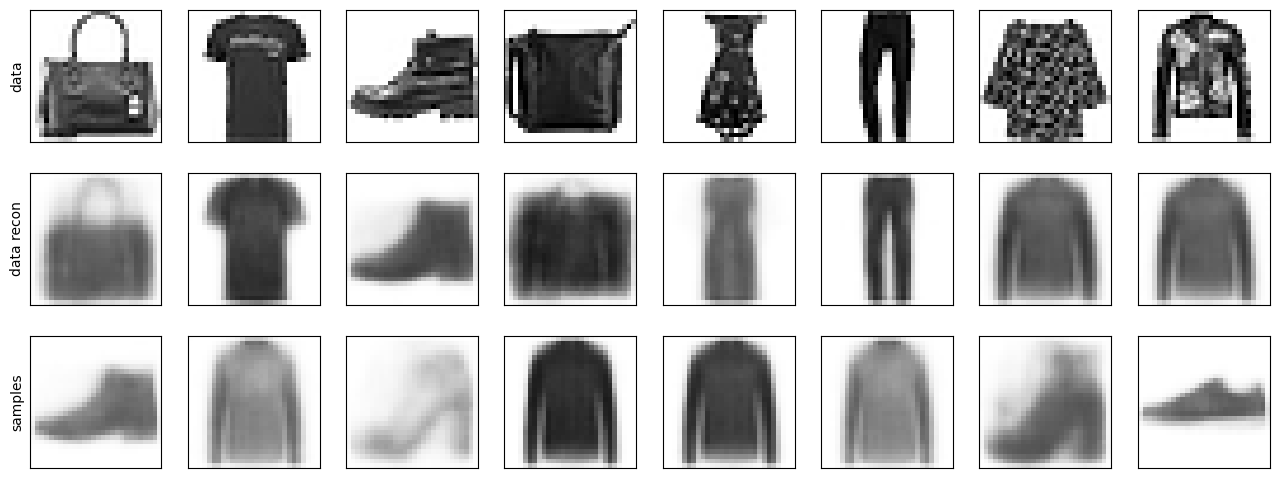

In [13]:
n_epochs = 50

for epoch in range(n_epochs):
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
        model.train(train_x)
        loss = []

    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES):
        loss.append(model.loss_function(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    display.clear_output()
    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {}".format(
            epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]
        )
    )

    plot_reconstruction(model, example_data)